# Programming Assignment: Numerical Optimization for Logistic Regression.

### Name: Khalid Isahak


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)

2. Read, complete, and run my code.

3. **Implement mini-batch SGD** and evaluate the performance.

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
    * Missing **the output after execution** will not be graded.
    
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo.  (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

6. On Canvas, submit the Google Drive/Dropbox/Github link to the HTML file.


## Grading criteria:

1. When computing the ```gradient``` and ```objective function value``` using a batch of samples, use **matrix-vector multiplication** rather than a FOR LOOP of **vector-vector multiplications**.

2. Plot ```objective function value``` against ```epochs```. In the plot, compare GD, SGD, and MB-SGD (with $b=8$ and $b=64$). The plot must look reasonable.

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [4]:
from sklearn import datasets
import numpy
x_sparse, y = datasets.load_svmlight_file('./diabetes.txt')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [5]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [6]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[ 0.1041963  -0.00310124 -0.01358383 -0.00330343  0.03886493 -0.05130504
   0.04458003 -0.0426148 ]]
test std = 
[[1.08885293 1.03913552 0.8957774  0.94658936 0.98392944 1.07663375
  1.05070127 0.95247081]]


## 1.4. Add a dimension of all ones

In [7]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [8]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg
    

In [9]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [10]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [11]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [12]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.5973146878700077
Objective value at t=2 is 0.5569908437038523
Objective value at t=3 is 0.5351638747474113
Objective value at t=4 is 0.5215622991720212
Objective value at t=5 is 0.5123905663145242
Objective value at t=6 is 0.5058964654976723
Objective value at t=7 is 0.5011433951978779
Objective value at t=8 is 0.49757929256031014
Objective value at t=9 is 0.494856179224429
Objective value at t=10 is 0.49274397331007014
Objective value at t=11 is 0.49108502163726264
Objective value at t=12 is 0.48976825024040754
Objective value at t=13 is 0.4887136137020592
Objective value at t=14 is 0.4878623252614898
Objective value at t=15 is 0.48717050534147055
Objective value at t=16 is 0.48660493614699796
Objective value at t=17 is 0.4861401572203284
Objective value at t=18 is 0.4857564382581906
Objective value at t=19 is 0.4854383391571947
Objective value at t=20 is 0.48517367104013936
Objective value at t=21 is 0.484952735

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [13]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [14]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [15]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.5331418662668062
Objective value at epoch t=1 is 0.5214506467931741
Objective value at epoch t=2 is 0.5350708557369019
Objective value at epoch t=3 is 0.5297524745538642
Objective value at epoch t=4 is 0.513063505151666
Objective value at epoch t=5 is 0.5194466628798519
Objective value at epoch t=6 is 0.5161818930249517
Objective value at epoch t=7 is 0.5113230035809593
Objective value at epoch t=8 is 0.512568790262442


Objective value at epoch t=9 is 0.5110363364413758
Objective value at epoch t=10 is 0.5023832342074888
Objective value at epoch t=11 is 0.5046639894001876
Objective value at epoch t=12 is 0.49699378962584584
Objective value at epoch t=13 is 0.5006179613908991
Objective value at epoch t=14 is 0.49500142810306846
Objective value at epoch t=15 is 0.4966358368496331
Objective value at epoch t=16 is 0.4966810594683901
Objective value at epoch t=17 is 0.4938599302392962
Objective value at epoch t=18 is 0.49173924832733007
Objective value at epoch t=19 is 0.49339587940888785
Objective value at epoch t=20 is 0.49179614014013556
Objective value at epoch t=21 is 0.4918302117441253
Objective value at epoch t=22 is 0.4901146469426013
Objective value at epoch t=23 is 0.48888163823892816
Objective value at epoch t=24 is 0.4897363352863243
Objective value at epoch t=25 is 0.4883036212413418
Objective value at epoch t=26 is 0.4886841307413336
Objective value at epoch t=27 is 0.4874420163309191
Objecti

# 4. Compare GD with SGD

Plot objective function values against epochs.

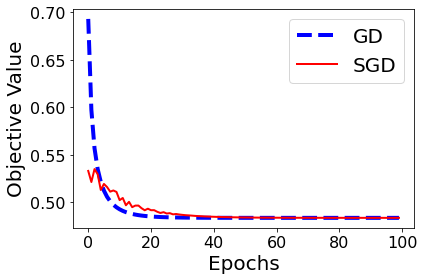

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', linewidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', linewidth=2)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Objective Value', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [17]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [18]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.2265625


In [19]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.1796875


# 6. Mini-batch SGD (fill the code)



## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [110]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: b-by-d matrix
#     yi: b-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
import numpy as np
def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    # Fill the function
    # Follow the implementation of stochastic_objective_gradient
    # Use matrix-vector multiplication; do not use FOR LOOP of vector-vector multiplications

    # Ensure xi and yi are numpy arrays for matrix operations
    xi = np.asarray(xi)
    yi = np.asarray(yi)
    
    xi_transposed = xi.T  # Transpose xi to make it a 1xb matrix
    
    yx = (np.dot(xi_transposed, yi)).T
    yxw = np.dot(yx, w)  # Matrix-vector multiplication

    
    loss = np.mean(np.log(1 + np.exp(-yxw)))  

    reg = (lam / 2) * np.sum(w**2)  # Scalar

    obj = loss + reg  # Scalar

    g_loss = -np.dot(yx.T, 1 / (1 + np.exp(yxw))) / b  # Matrix-vector multiplication, result is (d, 1)

    # Calculate the total gradient for the batch, including the regularization gradient
    g = g_loss + lam * w  # (d, 1)

    return obj, g

## 6.2. Implement mini-batch SGD

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_stochastic_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.


In [106]:

def mb_sgd(x, y, lam, b, stepsize, max_epoch=100, w=None):
    # Fill the function
    # Follow the implementation of sgd
    # Record one objective value per epoch (not per iteration!)
    # SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
    n, d = x.shape
    objvals = np.zeros(max_epoch)  # Store the objective values for each epoch

    if w is None:
        w = np.zeros((d, 1))  # Zero initialization for weights

    for epoch in range(max_epoch):
        # Randomly shuffle the samples at the beginning of each epoch
        rand_indices = np.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]

        objval_epoch = 0 

        # Iterate over mini-batches
        for i in range(0, n, b):
            xi = x_rand[i:i+b, :] 
            yi = y_rand[i:i+b,:]  
            
            obj, g = mb_stochastic_objective_gradient(w, xi, yi, lam, b)

            objval_epoch += obj * min(b, n-i)

            # Update the weights
            w -= stepsize * g

        stepsize *= 0.9  # Decrease step size


        objvals[epoch] = objval_epoch / n
        print('Objective value at epoch {} is {}'.format(epoch, objvals[epoch]))

    return w, objvals

## 6.3. Run MB-SGD

In [159]:
# MB-SGD with batch size b=8
lam = 1E-6 # do not change
b = 8 # do not change
stepsize = .00039 # you must tune this parameter

w, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch 0 is 0.679183402941017
Objective value at epoch 1 is 0.652766653059597
Objective value at epoch 2 is 0.6307057476487848
Objective value at epoch 3 is 0.6121896297749501
Objective value at epoch 4 is 0.5966026308602235
Objective value at epoch 5 is 0.5822708039243606
Objective value at epoch 6 is 0.5711338533914858
Objective value at epoch 7 is 0.5598500700052818
Objective value at epoch 8 is 0.5523524435794048
Objective value at epoch 9 is 0.5446367870967637
Objective value at epoch 10 is 0.5387143516075129
Objective value at epoch 11 is 0.5312008776481365
Objective value at epoch 12 is 0.5256756943310104
Objective value at epoch 13 is 0.5217036050484537
Objective value at epoch 14 is 0.518212899829477
Objective value at epoch 15 is 0.5133575283295999
Objective value at epoch 16 is 0.5114864855224953
Objective value at epoch 17 is 0.5067584176162663
Objective value at epoch 18 is 0.5051362806729325
Objective value at epoch 19 is 0.5032763892315398
Objective val

Objective value at epoch 24 is 0.4955113230600016
Objective value at epoch 25 is 0.4938145386034133
Objective value at epoch 26 is 0.49418058291594474
Objective value at epoch 27 is 0.4919840588831339
Objective value at epoch 28 is 0.4918526179728526
Objective value at epoch 29 is 0.4915139841376934
Objective value at epoch 30 is 0.49177759437397467
Objective value at epoch 31 is 0.4894468584995022
Objective value at epoch 32 is 0.4890751990366605
Objective value at epoch 33 is 0.4892007444402891
Objective value at epoch 34 is 0.4878124877326857
Objective value at epoch 35 is 0.48583060996167066
Objective value at epoch 36 is 0.4862645481949257
Objective value at epoch 37 is 0.4877280153985753
Objective value at epoch 38 is 0.4849468840954878
Objective value at epoch 39 is 0.4859680277332871
Objective value at epoch 40 is 0.4854012182644872
Objective value at epoch 41 is 0.48641370769690584
Objective value at epoch 42 is 0.48665955734703825
Objective value at epoch 43 is 0.483933029121

In [157]:
# MB-SGD with batch size b=64
lam = 1E-6 # do not change
b = 64 # do not change
stepsize = 0.00036 # you must tune this parameter

w, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch 0 is 0.6813322436326286
Objective value at epoch 1 is 0.6563975149489087
Objective value at epoch 2 is 0.6350622338619714
Objective value at epoch 3 is 0.6167729901366856
Objective value at epoch 4 is 0.6008381790095834
Objective value at epoch 5 is 0.5872300451322536
Objective value at epoch 6 is 0.5750909963583514
Objective value at epoch 7 is 0.5647377618180477
Objective value at epoch 8 is 0.5555055890922332
Objective value at epoch 9 is 0.5473511552868545
Objective value at epoch 10 is 0.5407021605066958
Objective value at epoch 11 is 0.5344068416177624
Objective value at epoch 12 is 0.5287282395798989
Objective value at epoch 13 is 0.5238759300087178
Objective value at epoch 14 is 0.5197508832351446
Objective value at epoch 15 is 0.5163725200914814
Objective value at epoch 16 is 0.511902640174434
Objective value at epoch 17 is 0.5091351334320289
Objective value at epoch 18 is 0.5063387285184546
Objective value at epoch 19 is 0.5040011547683217
Objective v

# 7. Plot and compare GD, SGD, and MB-SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

Hint: Logistic regression with $\ell_2$-norm regularization is a strongly convex optimization problem. All the algorithms will converge to the same solution. **In the end, the ``objective function value`` of the 4 algorithms will be the same. If not the same, your implementation must be wrong. Do NOT submit wrong code and wrong result!**

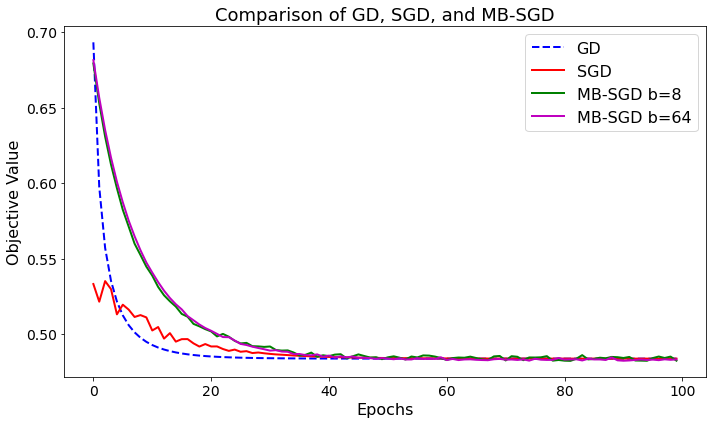

In [160]:
# plot the 4 curves:
import matplotlib.pyplot as plt



fig = plt.figure(figsize=(10, 6))

# Epochs for each algorithm
epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))
epochs_mbsgd8 = range(len(objvals_mbsgd8))
epochs_mbsgd64 = range(len(objvals_mbsgd64))

# Plotting
line0, = plt.plot(epochs_gd, objvals_gd, '--b', linewidth=2, label='GD')
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', linewidth=2, label='SGD')
line2, = plt.plot(epochs_mbsgd8, objvals_mbsgd8, '-g', linewidth=2, label='MB-SGD b=8')
line3, = plt.plot(epochs_mbsgd64, objvals_mbsgd64, '-m', linewidth=2, label='MB-SGD b=64')

# Labeling
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Objective Value', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.title('Comparison of GD, SGD, and MB-SGD', fontsize=18)
plt.tight_layout()

plt.show()

